### The AQIC and Fire Alarm projects are supported via NASA's Earth Science Technology Office (ESTO) from the Advanced Information Systems Technology (AIST) Program

# Fire Alarm: Science Data Platform for Wildfire and Air Quality API Demonstration

## Libraries, Functions and Inventories

The following libraries are needed to support accessing FireAlarm API. The functions called in this notebook are in the `firealarm_modules` folder.

### Libraries

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from IPython.display import Image
from owslib.wms import WebMapService
from urllib.request import urlopen
from PIL import Image as I
from PIL import ImageDraw, ImageFont

import firealarm_modules.plotting as plotting
import firealarm_modules.firealarm_processing as firealarm_processing

### Fire Alarm: Science Data Platform for Wildfire and Air Quality  DATA Inventory

The base url, https://ideas-digitaltwin.jpl.nasa.gov/nexus, is the entry to access FireAlarm API. In the following code snipet, it is used in conjunction with list endpoint to get a list of datasets.

In [2]:
BASE_URL = 'https://ideas-digitaltwin.jpl.nasa.gov'
NEXUS_URL = f'{BASE_URL}/nexus'
INSITU_URL = f'{BASE_URL}/insitu/1.0'

### Satellite and Model data inventory

In [3]:
aq_datasets = firealarm_processing.get_datasets()

In [4]:
pd.concat([aq_datasets[['GlobalAttrTitle', 'GlobalAttrSource']].head(), aq_datasets[['GlobalAttrTitle', 'GlobalAttrSource']].tail()])

,GlobalAttrTitle,GlobalAttrSource
0,MERRA-2 Global CDH,GES DISC
1,MERRA-2 Global PBLH,GES DISC
2,MERRA-2 Global TLML,GES DISC
3,MODIS Terra AOD 550 Dark Target Deep Blue Comb...,Giovanni
4,MODIS Terra Aerosol Optical Depth Land Ocean Mean,Giovanni
24,Sentinel-5P TROPOMI Methane CH4 California,GES DISC
25,Sentinel-5P TROPOMI Carbon Monoxide CO California,GES DISC
26,Sentinel-5P TROPOMI Tropospheric NO2 California,GES DISC
27,Sentinel-5P TROPOMI Total Ozone California,GES DISC
28,Sentinel-5P TROPOMI Sulphur Dioxide SO2 Califo...,GES DISC


### In-situ data inventory

In [5]:
insitu_collections = firealarm_processing.get_insitu_collections()
insitu_collections

,provider,project
0,AirNow,air_quality
1,AirNow,AQACF
2,GRIMM-Aethalometer,AQACF
3,PurpleAir,AQACF
4,QuantAQ,AQIC-Raw
5,QuantAQ,AQIC
6,QuantAQ,AQIC-Hourly
7,PurpleAir-GMU-Cal,air_quality
8,PurpleAir-GMU-Intermediate,air_quality
9,PurpleAir-GMU-Raw-Hourly,air_quality


In [6]:
airnow_sites = firealarm_processing.get_insitu_sites('air_quality', 'AirNow').drop_duplicates(['platform_short_name']).reset_index()
airnow_sites

,index,platform,platform_short_name,lat,lon,min_datetime,max_datetime
0,0,000010102,St. John's,47.652800,-52.816700,2018-01-01T00:00:00Z,2022-02-28T00:00:00Z
1,1,000010401,Mount Pearl,47.505000,-52.794700,2018-01-01T00:00:00Z,2022-02-28T00:00:00Z
2,2,000010501,Grand Falls Windsor,49.019400,-55.802800,2018-01-01T00:00:00Z,2021-03-31T00:00:00Z
3,3,000010601,Goose Bay,53.304700,-60.364400,2018-01-02T00:00:00Z,2024-03-31T00:00:00Z
4,4,000010602,MacPherson Avenue - Corner Brook,48.952240,-57.922070,2020-01-01T00:00:00Z,2022-02-28T00:00:00Z
...,...,...,...,...,...,...,...
3471,7059,TT1010003,Inchelium,48.296960,-118.202420,2018-01-09T00:00:00Z,2019-05-31T00:00:00Z
3472,7060,TT5420500,Santa Rosa Rancheria,36.233333,-119.765083,2018-01-01T00:00:00Z,2023-08-24T00:00:00Z
3473,7062,TT9209004,Miami,36.922222,-94.838890,2018-01-01T00:00:00Z,2024-03-31T00:00:00Z
3474,7064,UB1010001,Ulaanbaatar,47.928385,106.929470,2018-01-01T00:00:00Z,2024-03-31T00:00:00Z


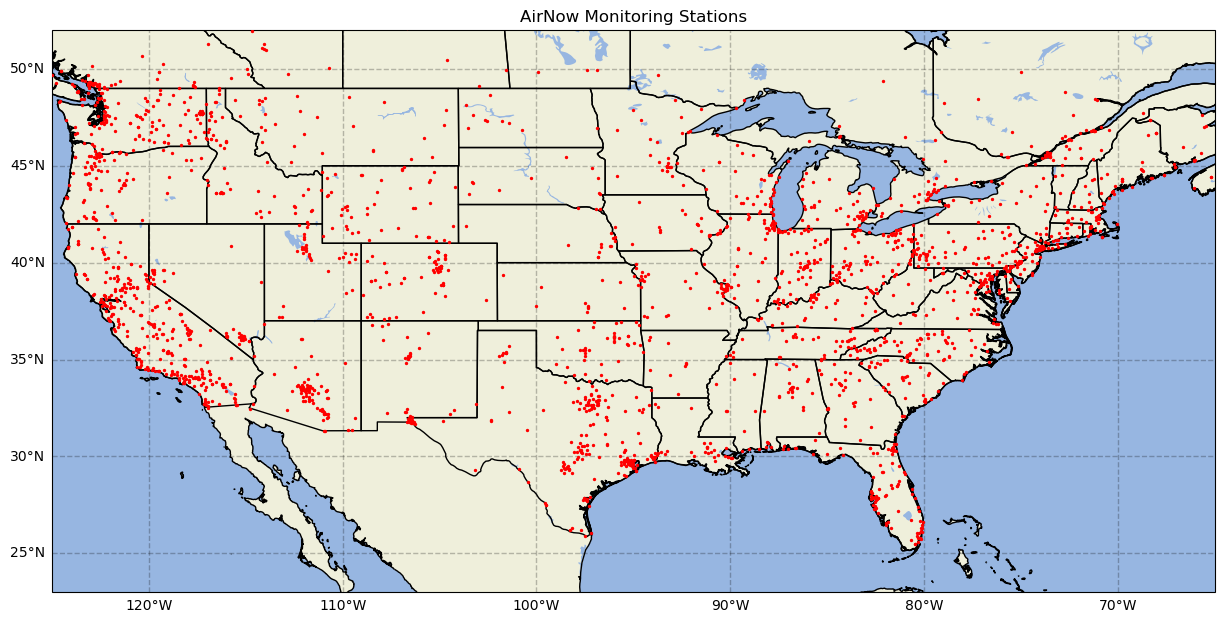

In [7]:
formatted_sites = [(s['lat'], s['lon'], s['platform_short_name']) for i,s in airnow_sites.iterrows()]
plotting.map_points(formatted_sites, region='usa', title='AirNow Monitoring Stations', legend=False, roads=False)

# Orbiting Carbon Observatory-3 (OCO-3) | Snapshot Area Maps (SAMs) | Zarr

NASA-JPL's OCO-3 is an instrument onboard the International Space Station that measures carbon dioxide in the Earth's atmosphere. OCO-3 is similar in design to its predecessor, OCO-2, with the addition of the Pointing Mirror Assembly (PMA) which essentially allows the instrument to focus its observations on the area surrounding a given location of interest on a single overflight. This is called a Snapshot Area Map, or SAM, and is the focus of this dataset. 

<div align="center">
    <figure>
        <img src="https://ocov3.jpl.nasa.gov/sams/plots/xco2/OCO3_Ops_B10305_r02_xco2_20200303_4719_fossil0005.png" width=500 />
        <figcaption>Example SAM over Los Angeles, CA, USA</figcaption>
    </figure>
</div>

This dataset was generated by taking [level 2 input files](https://disc.gsfc.nasa.gov/datasets/OCO3_L2_Lite_FP_10.4r/summary?keywords=oco3) and processing them into a level 3 SAM-only product on a fixed, global grid. The dataset was stored in the cloud-optimized Zarr format and then onboarded to the AQIC for access through the FireAlarm API.

## SAM Data Over Los Angeles, CA, USA

We start by visualizing a particular SAM over the following bounding box around Los Angeles.

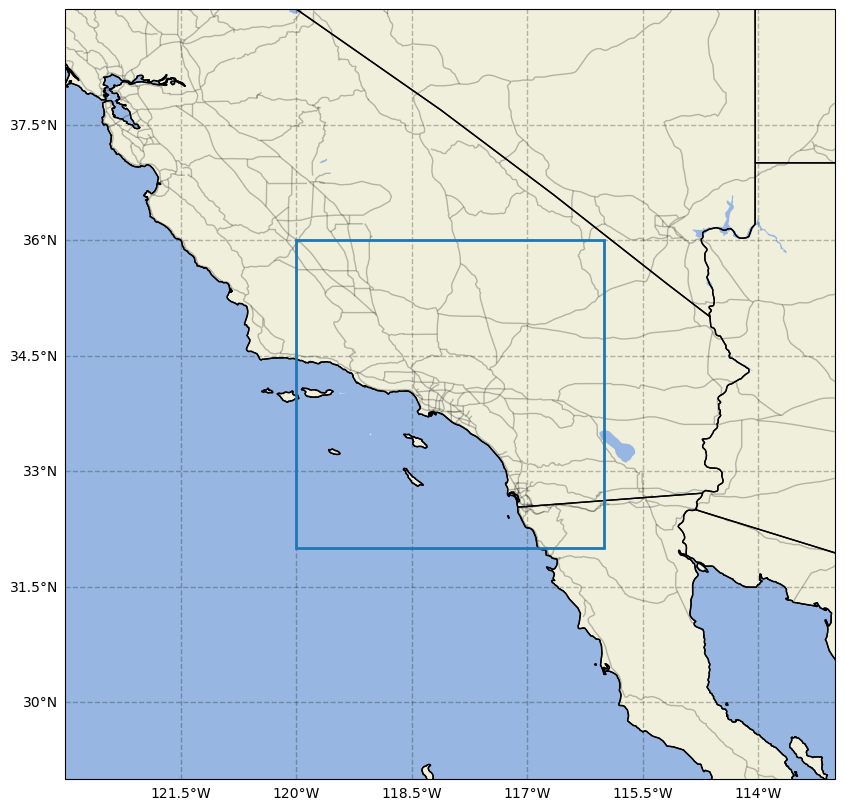

In [8]:
la_bb = {
    'min_lon': -120.0,
    'max_lon': -116.0,
    'min_lat': 32.0,
    'max_lat': 36.0
}

oco_start = datetime(2019, 9, 14)
oco_end = datetime(2023, 7, 1)

plotting.map_box(la_bb, padding=3)

In [9]:
la_sam_pre = firealarm_processing.data_subsetting('oco3_sams_l3_pre_qf', la_bb, datetime(2020, 8, 14), datetime(2020, 8, 15), 'xco2')
la_sam_post = firealarm_processing.data_subsetting('oco3_sams_l3_post_qf', la_bb, datetime(2020, 8, 14), datetime(2020, 8, 15), 'xco2')

https://ideas-digitaltwin.jpl.nasa.gov/nexus/datainbounds?ds=oco3_sams_l3_pre_qf&b=-120.0%2C32.0%2C-116.0%2C36.0&startTime=2020-08-14T00%3A00%3A00Z&endTime=2020-08-15T00%3A00%3A00Z

Waiting for response from FireAlarm...took 1.3412300839991076 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/datainbounds?ds=oco3_sams_l3_post_qf&b=-120.0%2C32.0%2C-116.0%2C36.0&startTime=2020-08-14T00%3A00%3A00Z&endTime=2020-08-15T00%3A00%3A00Z

Waiting for response from FireAlarm...took 1.3946667080017505 seconds


There are two datasets produced from the OCO-3 data, denoted by "pre QF" and "post QF". Source OCO-3 data includes a flag to indicate whether particular observations are "good" or "bad". Using this, we can filter the data to contain only "good" data. This is "post QF" (post quality_flag filtering) data. 

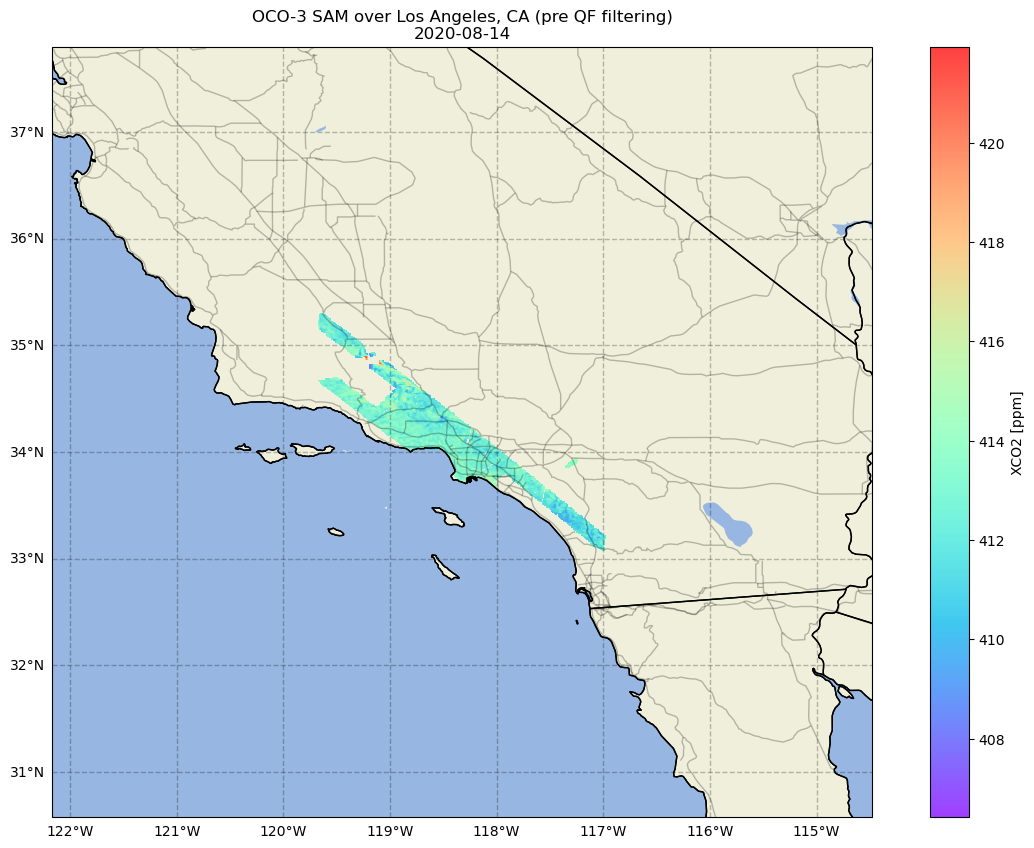

In [10]:
plotting.map_data(
    la_sam_pre[0], 
    f'OCO-3 SAM over Los Angeles, CA (pre QF filtering)\n{datetime(2020, 8, 14).strftime("%Y-%m-%d")}', 
    cb_label='XCO2 [ppm]'
)

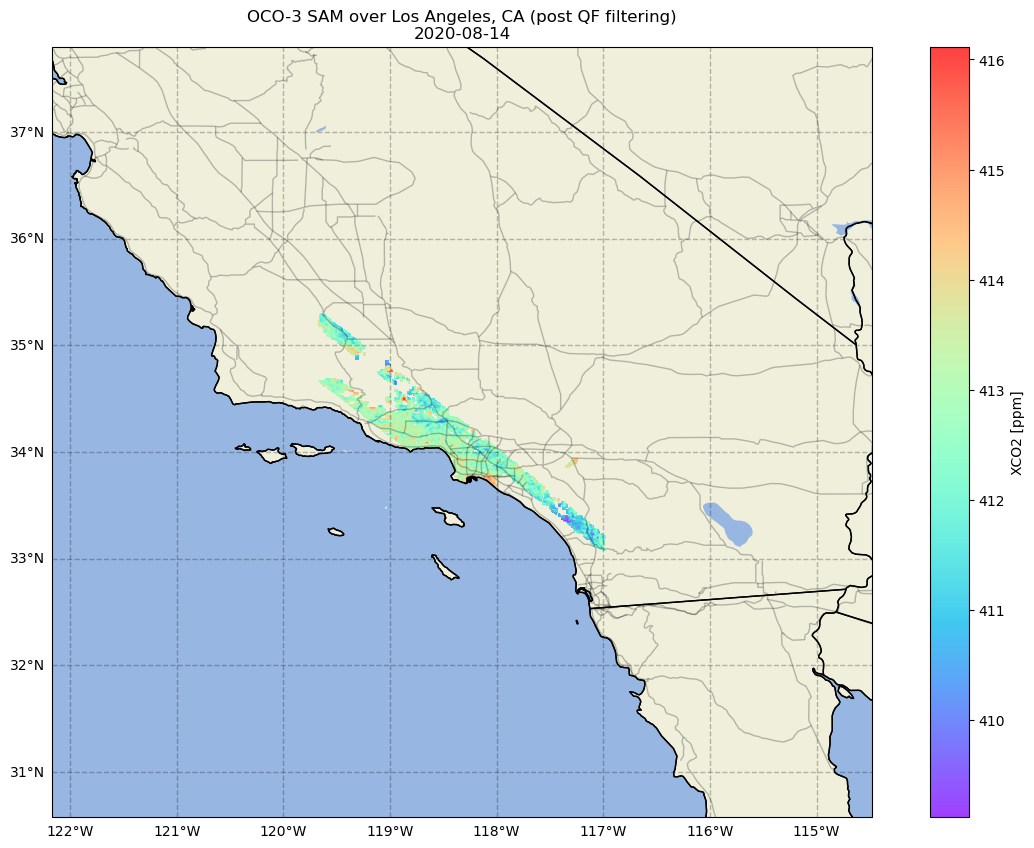

In [11]:
plotting.map_data(
    la_sam_post[0], 
    f'OCO-3 SAM over Los Angeles, CA (post QF filtering)\n{datetime(2020, 8, 14).strftime("%Y-%m-%d")}', 
    cb_label='XCO2 [ppm]'
)

## Use Case: CO2 Emissions During the Course of the COVID-19 Pandemic

The lockdowns in response to the COVID-19 pandemic led to many noticeable environmental changes. Among these was an observable dip in CO2 concentration which was restored to pre-COVID levels as restrictions eased.

In this section, we run time series on the OCO-3 SAM (post QF) dataset over the course of just over 2 years starting at the early stages of COVID lockdowns. We focus again on the LA area, as well as the city of Wuhan, China. 

In the time series, we can see an initial depression in XCO2 value lasting to around October 2020, from which there is a brief resurgence until another depression around mid-late 2021 corresponding to the emergence of the Delta variant of the SARS-CoV-2 virus. 

### Los Angeles

In [12]:
la_xco2_pre  = firealarm_processing.spatial_timeseries('oco3_sams_l3_pre_qf',  la_bb, oco_start, oco_end)
la_xco2_post = firealarm_processing.spatial_timeseries('oco3_sams_l3_post_qf', la_bb, oco_start, oco_end)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=oco3_sams_l3_pre_qf&minLon=-120.0&minLat=32.0&maxLon=-116.0&maxLat=36.0&startTime=2019-09-14T00%3A00%3A00Z&endTime=2023-07-01T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 20.795073874996888 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=oco3_sams_l3_post_qf&minLon=-120.0&minLat=32.0&maxLon=-116.0&maxLat=36.0&startTime=2019-09-14T00%3A00%3A00Z&endTime=2023-07-01T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 20.35586695800157 seconds


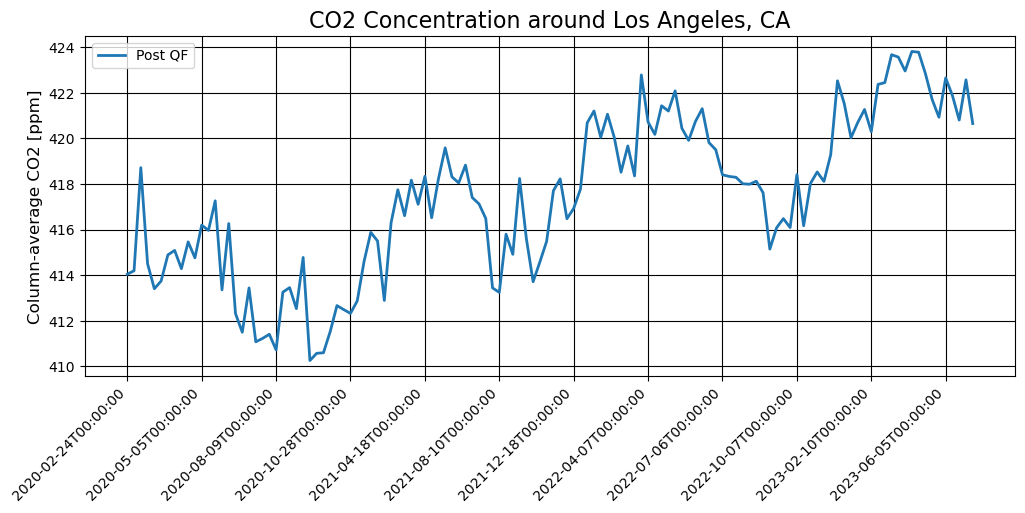

In [13]:
plotting.timeseries_plot_irregular(
    [
        # (la_xco2_pre['mean'], 'Pre QF'), 
        (la_xco2_post['mean'], 'Post QF'), 
    ], '', 'Column-average CO2 [ppm]', 'CO2 Concentration around Los Angeles, CA'
)

### Wuhan

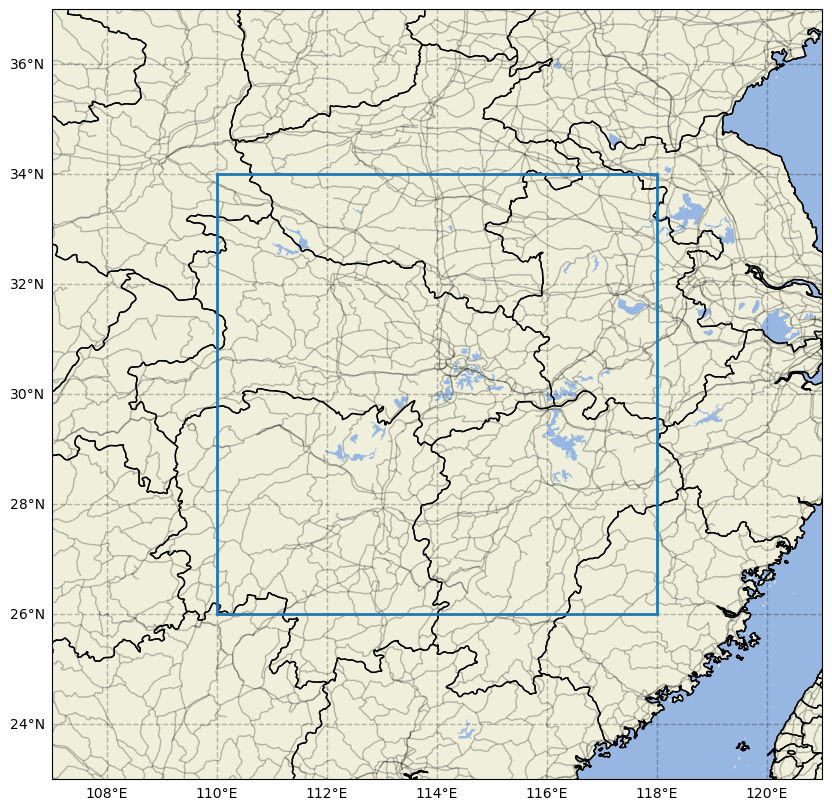

In [14]:
wuhan_bb = {
    'min_lon': 110,
    'max_lon': 118,
    'min_lat': 26,
    'max_lat': 34
}

oco_start = datetime(2018, 9, 14)
oco_end = datetime(2023, 7, 1)

plotting.map_box(wuhan_bb, padding=3)

In [15]:
wuhan_xco2_pre  = firealarm_processing.spatial_timeseries('oco3_sams_l3_pre_qf',  wuhan_bb, oco_start, oco_end)
wuhan_xco2_post = firealarm_processing.spatial_timeseries('oco3_sams_l3_post_qf', wuhan_bb, oco_start, oco_end)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=oco3_sams_l3_pre_qf&minLon=110&minLat=26&maxLon=118&maxLat=34&startTime=2018-09-14T00%3A00%3A00Z&endTime=2023-07-01T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 22.707516667000164 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=oco3_sams_l3_post_qf&minLon=110&minLat=26&maxLon=118&maxLat=34&startTime=2018-09-14T00%3A00%3A00Z&endTime=2023-07-01T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 22.080076875001396 seconds


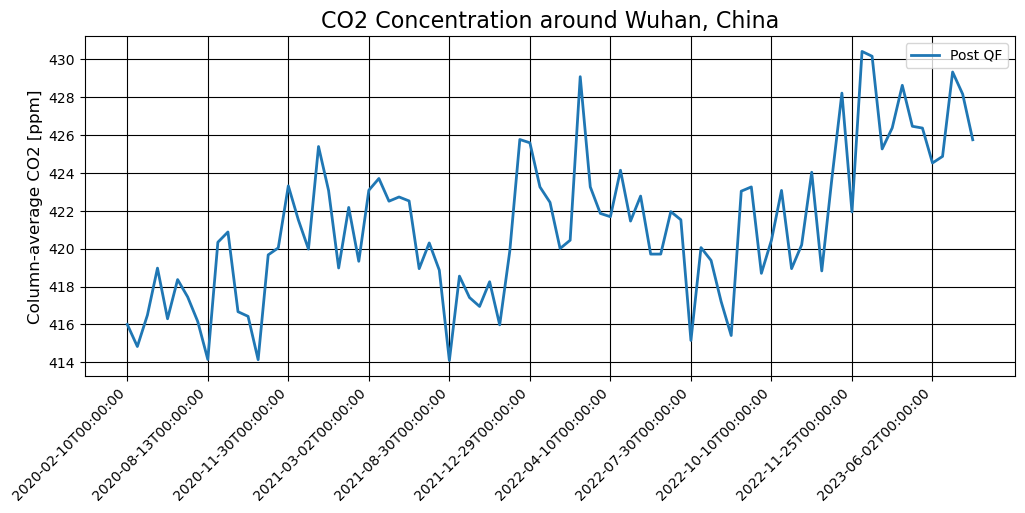

In [16]:
plotting.timeseries_plot_irregular(
    [
        # (wuhan_xco2_pre['maximum'], 'Pre QF'), 
        (wuhan_xco2_post['maximum'], 'Post QF'), 
    ], '', 'Column-average CO2 [ppm]', 'CO2 Concentration around Wuhan, China'
)

## Use Case: Monitoring CO2 Emissions from Europe's Largest Fossil Fueled Power Plant

A paper published on October 28 2022, in *Frontiers in Remote Sensing* by Nassar et al [1], made use of data from OCO-2 and OCO-3 (notably OCO-3 SAMs) to quantify emissions from Bełchatów Power Station in Poland, Europe's largest fossil fuel power plant. This section attempts to use the OCO-3 SAM dataset through the FireAlarm API to replicate some of the analyses produced in this study.

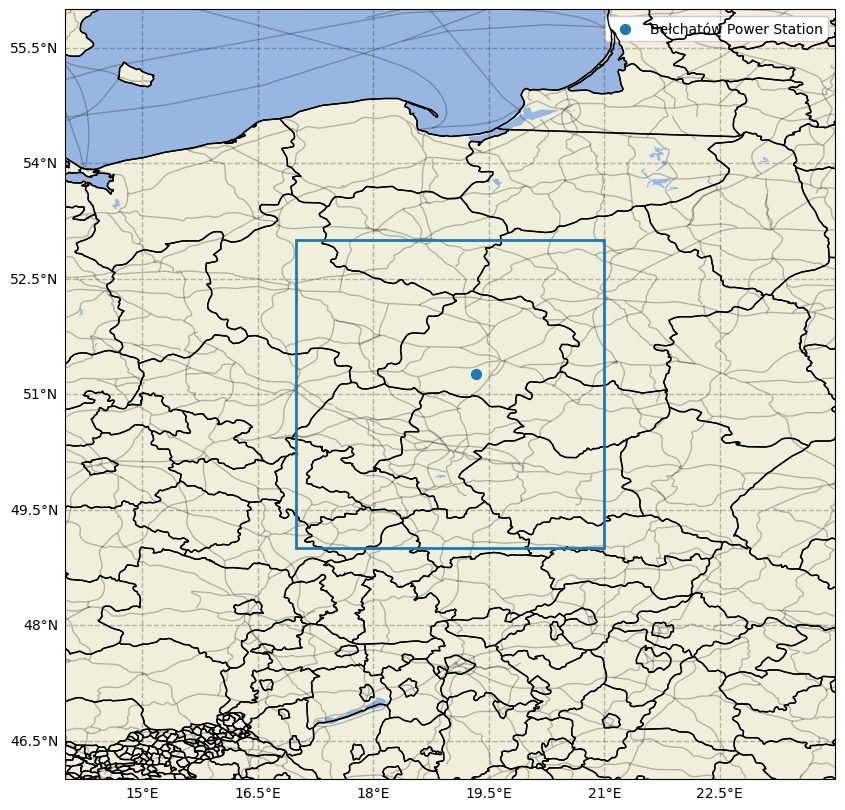

In [17]:
poland_ppt_bb = {
    'min_lon': 17,
    'max_lon': 21,
    'min_lat': 49,
    'max_lat': 53
}

oco_start = datetime(2020, 4, 10)
oco_end = datetime(2022, 6, 27)

plotting.map_box(poland_ppt_bb, [(51.266, 19.331, 'Bełchatów Power Station')], padding=3)

### CO2 Plumes

We first attempt to show the plumes of CO2 emissions from the power plant captured in OCO-3 SAMs on April 10th, 2020, and June 18th, 2021.

<div align="center">
    <figure>
        <img src="https://raw.githubusercontent.com/RKuttruff/FireAlarm-notebooks/3ea132d84a03e4c2f576a7f10f2764175e72d538/images/Be%C5%82chat%C3%B3w_SAMs.png" width=500 />
        <figcaption>Original SAMs on the dates in question, taken from the paper.</figcaption>
    </figure>
</div>


In [18]:
ppt_sams = [
    firealarm_processing.data_subsetting('oco3_sams_l3_post_qf', poland_ppt_bb, datetime(2020, 4, 10), datetime(2020, 4, 10), 'xco2'),
    firealarm_processing.data_subsetting('oco3_sams_l3_post_qf', poland_ppt_bb, datetime(2021, 6, 18), datetime(2021, 6, 18), 'xco2'),
]

https://ideas-digitaltwin.jpl.nasa.gov/nexus/datainbounds?ds=oco3_sams_l3_post_qf&b=17%2C49%2C21%2C53&startTime=2020-04-10T00%3A00%3A00Z&endTime=2020-04-10T00%3A00%3A00Z

Waiting for response from FireAlarm...took 1.1339443329998176 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/datainbounds?ds=oco3_sams_l3_post_qf&b=17%2C49%2C21%2C53&startTime=2021-06-18T00%3A00%3A00Z&endTime=2021-06-18T00%3A00%3A00Z

Waiting for response from FireAlarm...took 1.1056946250027977 seconds


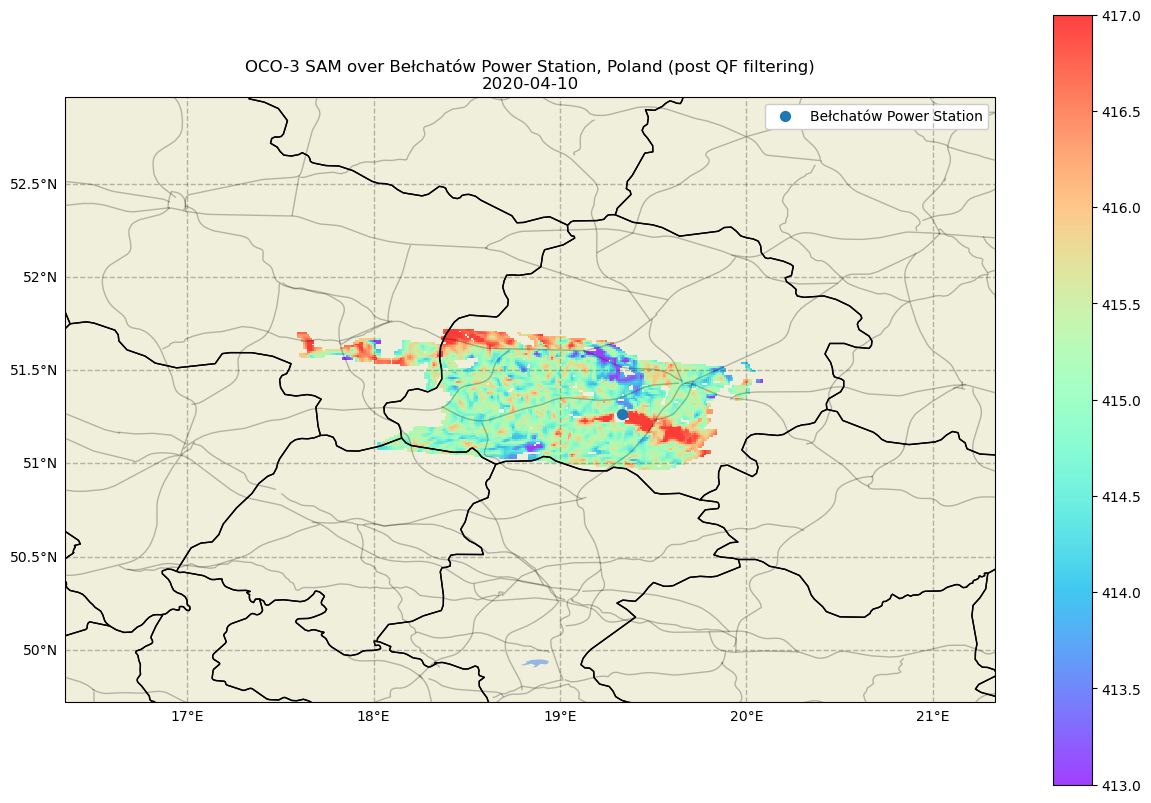

In [19]:
plotting.map_data(
    ppt_sams[0][0], 
    f'OCO-3 SAM over Bełchatów Power Station, Poland (post QF filtering)\n{datetime(2020, 4, 10).strftime("%Y-%m-%d")}',
    points=[(51.266, 19.331, 'Bełchatów Power Station')],
    padding=1.25,
    vmin=413, vmax=417
)

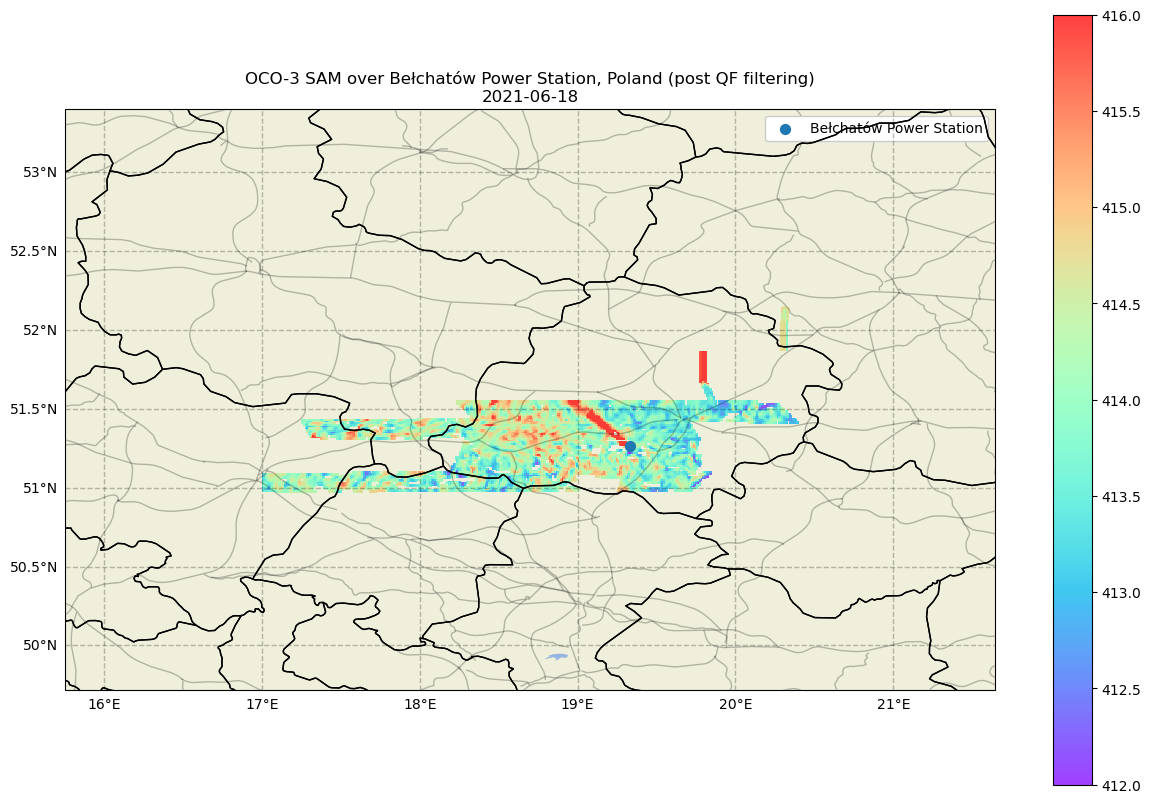

In [20]:
plotting.map_data(
    ppt_sams[1][0], 
    f'OCO-3 SAM over Bełchatów Power Station, Poland (post QF filtering)\n{datetime(2021, 6, 18).strftime("%Y-%m-%d")}',
    points=[(51.266, 19.331, 'Bełchatów Power Station')],
    padding=1.25,
    vmin=412, vmax=416
)

### Timeseries

The paper produces a timeseries of computed emissions from the power plant compared to its expected output. While we are unable to translate a similar timeseries from atmospheric concentration in parts per million to the paper's computed kilotons of CO2 per day (the techniques for doing so would be too complicated for the purposes this notebook), we can demonstrate a similar shape of the timeseries plot.

<div align="center">
    <figure>
        <img src="https://www.frontiersin.org/files/Articles/1028240/frsen-03-1028240-HTML-r1/image_m/frsen-03-1028240-g009.jpg" width=500 />
        <figcaption>Emissions timeseries from Nassar, et al.</figcaption>
    </figure>
</div>

In [21]:
ppt_timeseries = firealarm_processing.spatial_timeseries('oco3_sams_l3_post_qf', poland_ppt_bb, oco_start, oco_end)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=oco3_sams_l3_post_qf&minLon=17&minLat=49&maxLon=21&maxLat=53&startTime=2020-04-10T00%3A00%3A00Z&endTime=2022-06-27T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 13.731594624998252 seconds


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


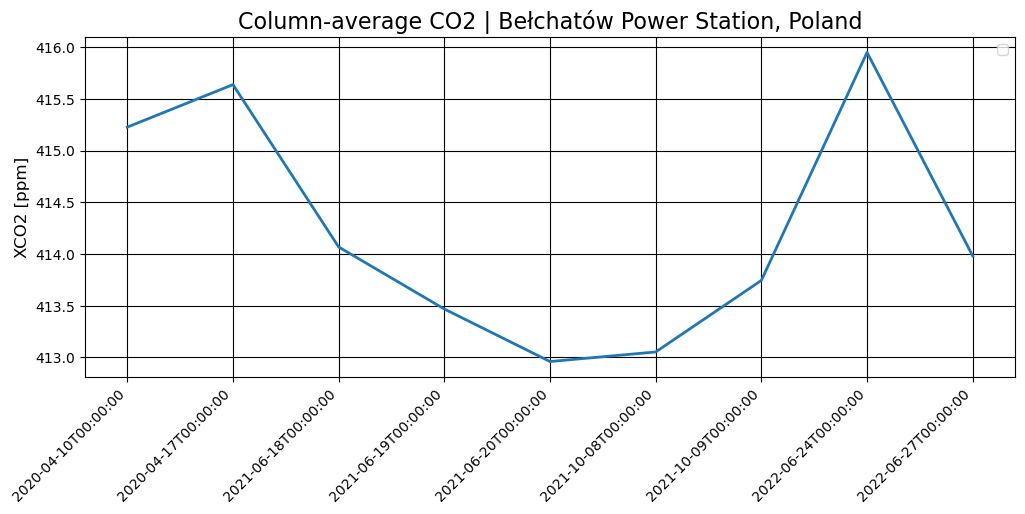

In [22]:
plotting.timeseries_plot_irregular(
    [
        #(ppt_timeseries['minimum'], None),
        (ppt_timeseries['mean'], '_hidden'),
        #(ppt_timeseries['maximum'], ''),
    ], 
    '', 
    'XCO2 [ppm]', 
    'Column-average CO2 | Bełchatów Power Station, Poland',
    times=[
        datetime(2020, 4, 10),
        datetime(2020, 4, 17),
        datetime(2021, 6, 18),
        datetime(2021, 6, 19),
        datetime(2021, 6, 20),
        datetime(2021, 10, 8),
        datetime(2021, 10, 9),
        datetime(2022, 6, 24),
        datetime(2022, 6, 27),
    ]
)

For the sake of completeness, we also include a timeseries over Bełchatów over the timeframe of our previous section.

In [23]:
oco_start = datetime(2018, 9, 14)
oco_end = datetime(2023, 7, 1)

ppt_timeseries = firealarm_processing.spatial_timeseries('oco3_sams_l3_post_qf', poland_ppt_bb, oco_start, oco_end)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=oco3_sams_l3_post_qf&minLon=17&minLat=49&maxLon=21&maxLat=53&startTime=2018-09-14T00%3A00%3A00Z&endTime=2023-07-01T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 21.30177391700272 seconds


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


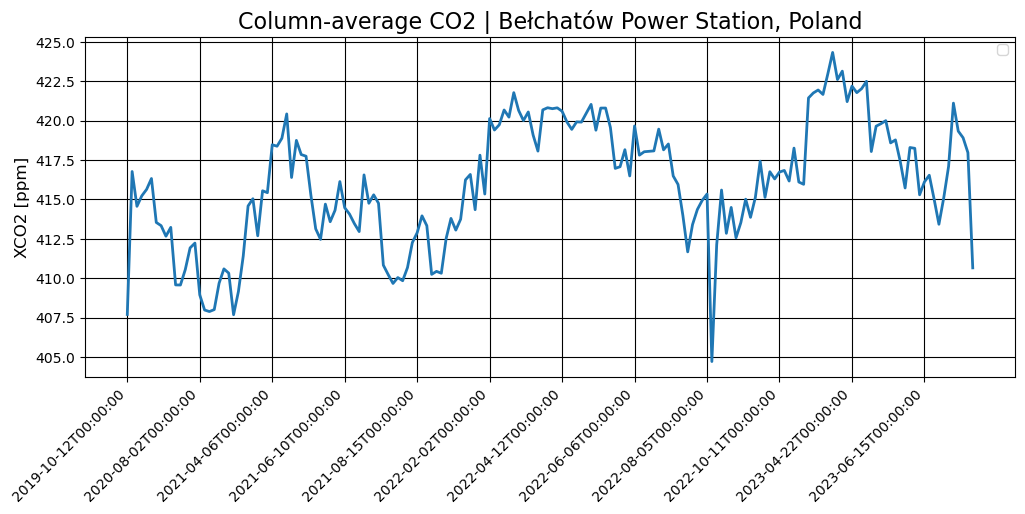

In [24]:
plotting.timeseries_plot_irregular(
    [
        #(ppt_timeseries['minimum'], None),
        (ppt_timeseries['mean'], '_hidden'),
        #(ppt_timeseries['maximum'], ''),
    ], 
    '', 
    'XCO2 [ppm]', 
    'Column-average CO2 | Bełchatów Power Station, Poland',
)

[1] Nassar R, Moeini O, Mastrogiacomo J-P, O’Dell CW, Nelson RR, Kiel M, Chatterjee A, Eldering A and Crisp D (2022), Tracking CO2 emission reductions from space: A case study at Europe’s largest fossil fuel power plant. Front. Remote Sens. 3:1028240.
doi: 10.3389/frsen.2022.1028240